# DAY 2

# Now creating a new script for first computing density from the dataset, then creating a grid with the same x-distance, then computing windstress and aligning with the ferrybox data by interpolating windstress data to the ferrybox.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from pathlib import Path
import cmocean as cmo
import numpy as np
import gsw
from pathlib import Path
from pyproj import Geod
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d



In [ ]:
# Function to load ONE file
def load_files(filepath: str | Path) -> pd.DataFrame:
    """
    Read an SBE text export that has metadata lines before the real header.
    Returns a tidy DataFrame with an extra 'datetime' column.
    """
    filepath = Path(filepath)

    # detect how many metadata lines to skip ------------------
    with filepath.open('r', encoding='latin1') as f:
        for i, line in enumerate(f):
            if line.strip().startswith("Date") and "Time" in line:
                skiprows = i
                break

    # read the rest ------------------------------------------
    df = pd.read_csv(
        filepath,
        sep=r'\s+',                 # whitespace delimiter
        skiprows=skiprows,          # jump over metadata
        encoding='latin1'
    )

    # combine date/time to real datetime ----------------------
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df['source']   = filepath.stem   # keep the filename → handy for legends
    df = df.iloc[1:]                # drop the first data row
    return df


# 2.  Load desired files

files = [
    #r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\224_2025-05-06_07.35.09__to_Skagen_741601.txt", #Dag 1 
    #r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\2025-05-07_07.11.44_Skagen_to__741601.txt", # Halva dag 2
    #r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\225_2025-05-07_07.11.44_Skagen_to_Skagen_741601.txt", # Hela dag 2
    r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\2025-05-08_07.24.29_Skagen_to__741601.txt" #Dag 3
]
dfs = [load_files(f) for f in files]

# Concatenate if you just want one big table:
df_all = pd.concat(dfs, ignore_index=True)

Remove/Interpolate the outlier in the transect from skagen to gbg, last day

In [ ]:
# New way thats working
# There is one outlier in the temp data, I will flag it and then interpolate inbetween

# # flag outliers
# bad = df_all['Temp_in_SBE38'] > 100            # any value > 100 °C is impossible  
# df_all.loc[bad, 'Temp_in_SBE38'] = np.nan      # set those outliers to NaN

df_all['Temp_in_SBE38'] = df_all['Temp_in_SBE38'].mask(df_all['Temp_in_SBE38'] > 100)

# interpolate the gaps
df_all = df_all.set_index('datetime')              # make time the index  
df_all['Temp_in_SBE38'] = df_all['Temp_in_SBE38'].interpolate('time')  # linear fill in time  
df_all = df_all.reset_index()                      # restore datetime as a column

Get the sigma density and Cons. temp and abs. sal

In [ ]:
# Convert everything to TEOS-10
SP  = df_all['Salinity_SBE45'].to_numpy()   # practical salinity is what we have in the dataset, will convert to Absolute sal
T   = df_all['Temp_in_SBE38'].to_numpy()    # in-situ temp (°C, ITS-90), will convert to Conservative T
p   = df_all['pressure'].to_numpy() / 100.0    # mbar → dbar  (1 dbar = 100 mbar)
lon = df_all['Longitude'].to_numpy()
lat = df_all['Latitude'].to_numpy()

SA = gsw.SA_from_SP(SP, p, lon, lat)    # absolute salinity
CT = gsw.CT_from_t(SA, T, p)            # conservative temp

# Store everything in the the dataset
df_all['SA'] = SA
df_all['CT'] = CT
df_all['press_db'] =p
df_all['sigma0'] = gsw.sigma0(SA, CT)       # potential density anomaly σθ

Compute boyancy and Boyancy gradient

In [ ]:
# Constants
g = 9.81                    # Gravity (m/s²)
target_depth = 2.0          # Target depth for buoyancy analysis (m)
depth_window = 0.5          # Allowed variation around target depth (± m)
dx = 150                 # Regular horizontal resolution (m)
geod = Geod(ellps="WGS84")  # Geodesic calculator

# Step 1: Convert pressure to depth and filter around 2 m
df_all['Depth'] = -gsw.z_from_p(df_all['pressure'] / 100, df_all['Latitude'])
depth = df_all["Depth"].to_numpy()
mask = np.abs(depth - target_depth) <= depth_window
df_near_depth = df_all[mask].copy()

# Step 2: Compute buoyancy from potential density anomaly
lon = df_near_depth["Longitude"].to_numpy()
lat = df_near_depth["Latitude"].to_numpy()
sigma0 = df_near_depth["sigma0"].to_numpy()
rho = sigma0 + 1000.0
rho0 = np.nanmean(rho)
b = g * (1 - (rho / rho0))  # Buoyancy in m/s²

# Step 3: Compute cumulative distance along the ship track
_, _, step = geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])
dist = np.concatenate(([0.0], np.cumsum(step)))

# Step 4: Interpolate buoyancy onto regular spatial grid
d_reg = np.arange(0, dist[-1], dx)
b_reg = interp1d(dist, b, bounds_error=False, fill_value=np.nan)(d_reg)
b_reg_smooth = gaussian_filter1d(b_reg, sigma=2)  # or use uniform_filter1d  sigma=2 on 1000 m grid ≈ 2 km smoothing scale — reasonable for mesoscale signals.


# Step 5: Compute horizontal buoyancy gradient ∂b/∂x
#dbdx_reg = np.gradient(b_reg, dx)
dbdx_reg = np.gradient(b_reg_smooth, dx)


# Step 6: Interpolate gradient back to original (irregular) positions
buoy_grad = np.interp(dist, d_reg, dbdx_reg, left=np.nan, right=np.nan)

# Step 7: Store in cleaned dataframe
df_clean = df_near_depth.copy()
df_clean["buoy_grad"] = buoy_grad

# Summary output
print("\n--- BUOYANCY ANALYSIS SUMMARY ---")
print(f"Target depth: {target_depth} m ± {depth_window} m")
print(f"Data points total: {len(depth)}")
print(f"Points near target depth: {np.sum(mask)}")

print("\n--- DEPTH RANGE ---")
print(f"Min depth: {np.nanmin(depth):.3f} m")
print(f"Max depth: {np.nanmax(depth):.3f} m")

print("\n--- DENSITY ---")
print(f"rho0 (mean): {rho0:.3f} kg/m³")
print(f"rho range: {np.nanmin(rho):.3f} – {np.nanmax(rho):.3f} kg/m³")
print(f"buoyancy (b) range: {np.nanmin(b):.2e} – {np.nanmax(b):.2e} m/s²")

print("\n--- DISTANCE ALONG TRACK ---")
print(f"Step sizes (m): min {np.min(step):.1f}, max {np.max(step):.1f}")
print(f"Total distance: {dist[-1]:.1f} m")

print("\n--- INTERPOLATED BUOYANCY ---")
print(f"b_reg range: {np.nanmin(b_reg):.2e} – {np.nanmax(b_reg):.2e} m/s²")
print(f"Interpolated grid points: {len(b_reg)}")

print("\n--- BUOYANCY GRADIENT (∂b/∂x) ---")
print(f"Gradient range: {np.nanmin(dbdx_reg):.2e} – {np.nanmax(dbdx_reg):.2e} s⁻²")

print("\n--- FINAL GRADIENT ON ORIGINAL POINTS ---")
print(f"Range: {np.nanmin(buoy_grad):.2e} – {np.nanmax(buoy_grad):.2e} s⁻²")
print(f"Non-NaN values: {np.sum(~np.isnan(buoy_grad))} / {len(buoy_grad)}")



--- BUOYANCY ANALYSIS SUMMARY ---
Target depth: 2.0 m ± 0.5 m
Data points total: 351
Points near target depth: 351

--- DEPTH RANGE ---
Min depth: 1.802 m
Max depth: 2.033 m

--- DENSITY ---
rho0 (mean): 1021.378 kg/m³
rho range: 1017.980 – 1023.283 kg/m³
buoyancy (b) range: -1.83e-02 – 3.26e-02 m/s²

--- DISTANCE ALONG TRACK ---
Step sizes (m): min 0.0, max 382.8
Total distance: 102559.8 m

--- INTERPOLATED BUOYANCY ---
b_reg range: -1.83e-02 – 3.26e-02 m/s²
Interpolated grid points: 684

--- BUOYANCY GRADIENT (∂b/∂x) ---
Gradient range: -9.21e-06 – 1.42e-05 s⁻²

--- FINAL GRADIENT ON ORIGINAL POINTS ---
Range: -9.08e-06 – 1.37e-05 s⁻²
Non-NaN values: 350 / 351


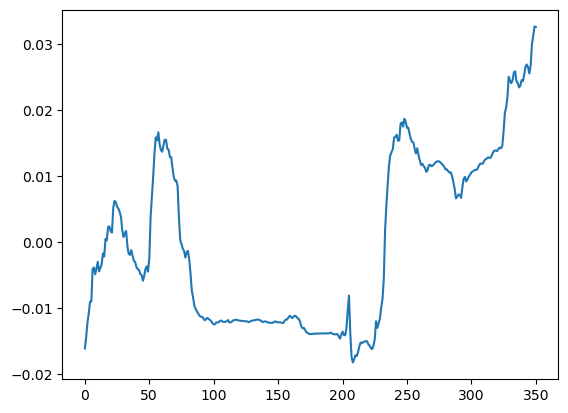

In [ ]:
plt.plot(b)

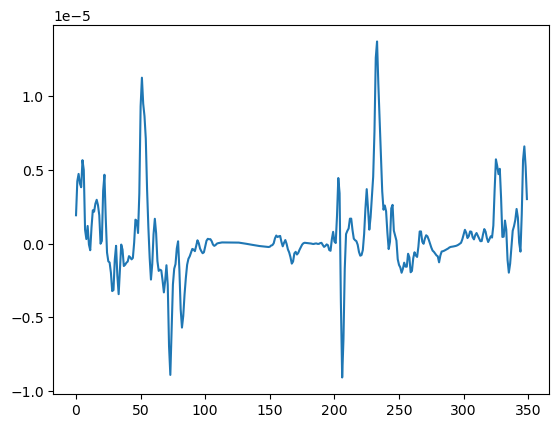

In [ ]:
plt.plot(buoy_grad)

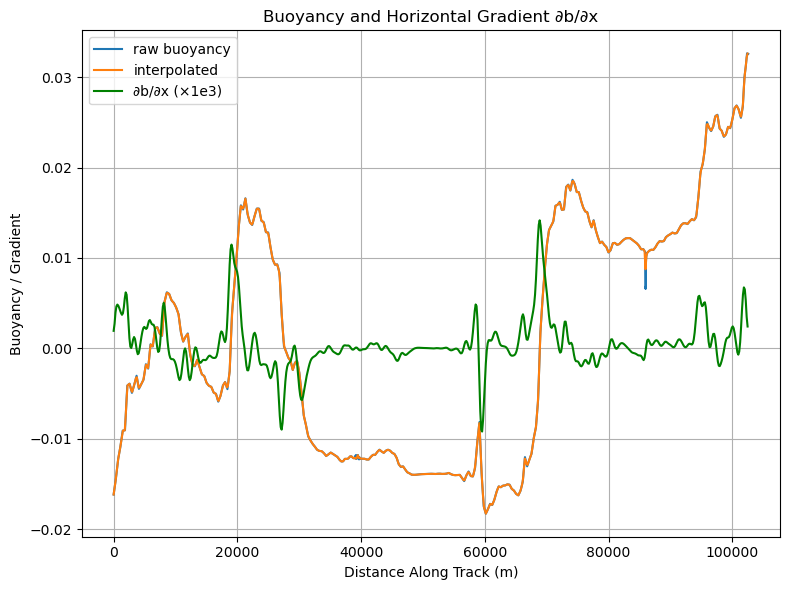

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(dist, b, label='raw buoyancy')               # original buoyancy (irregular)
plt.plot(d_reg, b_reg, label='interpolated')          # regular grid
plt.plot(d_reg, dbdx_reg * 1e3, label='∂b/∂x (×1e3)', color='green')

plt.xlabel('Distance Along Track (m)')
plt.ylabel('Buoyancy / Gradient')
plt.legend()
plt.title('Buoyancy and Horizontal Gradient ∂b/∂x')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("dbdx_reg shape:", dbdx_reg.shape)
print("d_reg shape:", d_reg.shape)


dbdx_reg shape: (684,)
d_reg shape: (684,)


In [ ]:
# saving the regular grid in the dataframe

df_dbdx = pd.DataFrame({
    "distance_m": d_reg,
    "buoyancy": b_reg,
    "dbdx": dbdx_reg})


In [ ]:
print(f"Total points: {len(df_all)}")
print(f"Within 2±0.5 m: {np.sum(mask)}")
print(f"Removed: {len(df_all) - np.sum(mask)}")


Total points: 351
Within 2±0.5 m: 351
Removed: 0


Open the weather data to compute the Ekman bouyancy flux (Dont mind the position data)

In [ ]:
df_wind = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_weather.csv")
# df_pos = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_position.csv")

In [ ]:
df_wind['ts'] = pd.to_datetime(df_wind['ts']).dt.round('1s')
# df_pos['ts'] = pd.to_datetime(df_pos['ts']).dt.round('1s')

# df = pd.merge(df_pos, df_wind, on='ts', how='inner')

In [ ]:
df_wind = df_wind.rename(columns={'ts': 'Time'})
df_wind = df_wind.rename(columns={'longitude': 'Longitude'})
df_wind = df_wind.rename(columns={'latitude': 'Latitude'})

Compute windstress

In [ ]:
# Get windstress

# ── 2.  vectorised air-density ρ_a(T, p, RH) ───────────────────────────
T   = df_wind['airtemp'].to_numpy(float)         # °C
P   = df_wind['airpressure'].to_numpy(float) * 100    # hPa → Pa
RH  = df_wind['humidity'].to_numpy(float) / 100     # %

Rd, Rv = 287.05, 461.5
es = 611.2 * np.exp((17.67 * T) / (T + 243.5))   # Pa (sat. vapour press.)
e  = RH * es                                     # Pa (actual vapour press.)
rho_air = (P - e) / (Rd * (T + 273.15)) + e / (Rv * (T + 273.15))

# ── 3.  wind-vector components (u, v) from speed + “from” direction ────
U     = df_wind['windspeed'].to_numpy(float)          # m s⁻¹
theta_wind = np.deg2rad(df_wind['winddir'].to_numpy(float))

u = -U * np.sin(theta_wind)      # eastward (+ = toward east)
v = -U * np.cos(theta_wind)      # northward (+ = toward north)

# ── 4.  constant drag coefficient & wind-stress components ─────────────
Cd   = 1.5e-3                                    # dimensionless
tau  = rho_air * Cd * U**2                       # magnitude  (N m⁻²)
tau_x = rho_air * Cd * U * u                     # eastward stress
tau_y = rho_air * Cd * U * v                     # northward stress

# store in DataFrame
df_wind['tau']   = tau
df_wind['tau_x'] = tau_x
df_wind['tau_y'] = tau_y
df_wind['theta_wind'] = theta_wind
df_wind['u_wind'] = u
df_wind['v_wind'] = v


# ── 5.  quick sanity print ─────────────────────────────────────────────
print(df_wind[['tau', 'tau_x', 'tau_y']].head())

        tau     tau_x     tau_y
0  0.021691 -0.004510 -0.021217
1  0.020434 -0.004597 -0.019910
2  0.018033  0.008466 -0.015922
3  0.011727 -0.001429 -0.011640
4  0.027085  0.001889 -0.027019


Sortera winddatan och ferrybox datan på tid för att kunna aligna dom

In [ ]:
df_all['datetime'] = pd.to_datetime(df_all['Date'].astype(str) + ' ' + df_all['Time'].astype(str))
df_wind['datetime'] = pd.to_datetime(df_wind['Time'])

df_all = df_all.sort_values('datetime')
df_wind = df_wind.sort_values('datetime')  

In [ ]:
# Add distance to df_clean (which corresponds to the buoyancy and positions)
df_clean['dist_m'] = dist


In [ ]:
wind_interp_cols = ['tau_x', 'tau_y', 'tau', 'theta_wind']

# Interpolate wind variables to df_clean['datetime'] first
df_wind = df_wind.set_index('Time')

for var in wind_interp_cols:
    interp_func = interp1d(df_wind.index.astype(np.int64), df_wind[var], bounds_error=False, fill_value=np.nan)
    df_clean[var] = interp_func(df_clean['datetime'].astype(np.int64))

# Now interpolate to regular distance grid
for var in wind_interp_cols:
    interp_func = interp1d(df_clean["dist_m"], df_clean[var], bounds_error=False, fill_value=np.nan)
    df_dbdx[var] = interp_func(d_reg)




Compute corilois and then EBF

In [ ]:
omega = 7.2921 * 10**-5  # Earth's rotation rate in rad/s
theta = 57  # Latitude in degrees

# Convert to radians
theta_rad = np.deg2rad(theta)

# Compute Coriolis parameter
f = 2 * omega * np.sin(theta_rad)

print(f"Coriolis parameter at {theta}°: {f:.3e} s⁻¹")


Coriolis parameter at 57°: 1.223e-04 s⁻¹


In [ ]:
# Constants
Cp = 4000 # J kg-1 K-1 # specific heat of water
# alpha = 10**-4
#alpha = 5.7
df_clean['alpha'] = gsw.alpha(df_clean['SA'], df_clean['CT'], df_clean['pressure'] / 100)
alpha = df_clean['alpha']
#alpha_const = 2*10**-4
g = 9.82
#tau_const = 0.02


# prepare the two source tables
bx   = df_clean[['datetime', 'buoy_grad', 'Longitude', 'Latitude']]      
tau  = df_clean[['datetime','tau']]  # 

# inner-join ⇒ keeps only timestamps present in **both** tables
combo = pd.merge(bx, tau, on='datetime', how='inner')
combo = pd.merge(combo, df_clean[['datetime', 'alpha']], on='datetime', how='left')

#combo['Q_EBF'] = -((combo['buoy_grad'] * combo['tau']) / (f)) * ((Cp) / (alpha * g))
combo['Q_EBF'] = -((combo['buoy_grad'] * combo['tau']) / f) * (Cp / (alpha * g))


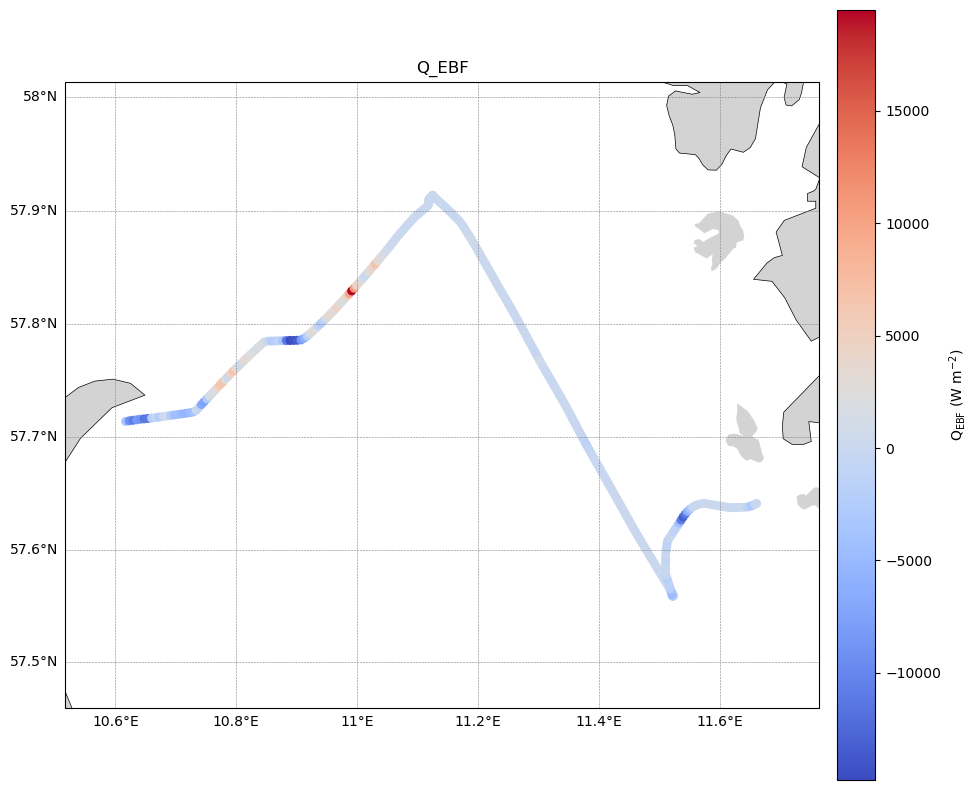

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Define extent with buffer
lat_min, lat_max = combo['Latitude'].min(), combo['Latitude'].max()
lon_min, lon_max = combo['Longitude'].min(), combo['Longitude'].max()
extent = [lon_min - 0.1, lon_max + 0.1, lat_min - 0.1, lat_max + 0.1]

ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Gridlines with labels only on left and bottom
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color="gray", linestyle="--")
gl.top_labels = False
gl.right_labels = False

# Scatter plot of Q_EBF
sc = ax.scatter(combo['Longitude'], combo['Latitude'],
                c=combo['Q_EBF'], cmap='coolwarm', s=30,
                transform=ccrs.PlateCarree())

# Colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Q$_{\\mathrm{EBF}}$ (W m$^{-2}$)')

ax.set_title('Q_EBF')
plt.tight_layout()
plt.show()


# Some diagnostics

In [ ]:
combo['Q_EBF'].describe()

count      350.000000
mean      -325.164804
std       3121.645843
min     -14769.262853
25%       -150.907503
50%         -3.520608
75%        110.536945
max      19486.755963
Name: Q_EBF, dtype: float64

In [ ]:
print(combo['buoy_grad'].describe())


count    3.500000e+02
mean     3.901062e-07
std      2.551880e-06
min     -9.078547e-06
25%     -5.443951e-07
50%      3.018118e-08
75%      7.300475e-07
max      1.373397e-05
Name: buoy_grad, dtype: float64


In [ ]:
print(combo['tau'].describe())


count    351.000000
mean       0.038672
std        0.046575
min        0.000000
25%        0.004504
50%        0.016843
75%        0.069891
max        0.278683
Name: tau, dtype: float64


In [ ]:
omega = 7.2921e-5
theta = np.deg2rad(57)
f = 2 * omega * np.sin(theta)

alpha_mean = np.nanmean(df_clean['alpha'])  # make sure you're using computed values
g = 9.81
Cp = 4000

scaling = Cp / (f * alpha_mean * g)
print(f"f = {f:.2e} s⁻¹")
print(f"mean alpha = {alpha_mean:.2e} 1/K")
print(f"scaling factor Cp / (f * alpha * g) = {scaling:.2e}")


f = 1.22e-04 s⁻¹
mean alpha = 1.63e-04 1/K
scaling factor Cp / (f * alpha * g) = 2.05e+10


# get ADCP data to get the alongfront wind

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime as dt
import pandas as pd
import gsw_xarray as gsw
from cmocean import cm as cmo  
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


############## DAG 3 ##################
file_path = r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\adcp0508_postpro20may.txt" # Dag 3

raw = pd.read_csv(file_path, sep="\t", skiprows=12, engine="python")
raw = raw.iloc[3:-3].reset_index(drop=True)

raw = raw.map(lambda x: str(x).replace(",", "."))
numeric_cols = raw.columns.drop(['    "FLat"', '    "FLon"', '    "LLat"', '    "LLon"'])
raw[numeric_cols] = raw[numeric_cols].astype(float)

east  = raw[[f"Eas{'.'+str(i) if i else ''}" for i in range(10)]].to_numpy()
north = raw[[f"Nor{'.'+str(i) if i else ''}" for i in range(10)]].to_numpy()

t = [dt.datetime(2000+int(y), int(m), int(d), int(HH), int(MM), int(SS))
     for y, m, d, HH, MM, SS in raw[['YR','MO','DA','HH','MM','SS']].to_numpy()]

import pytz

# Step 1: Assign UTC+2 (local time zone)
local_tz = pytz.timezone('Europe/Stockholm')
t_localized = [local_tz.localize(time) for time in t]

# Step 2: Convert to UTC and remove tz info
t_utc = [time.astimezone(pytz.utc).replace(tzinfo=None) for time in t_localized]


depth = np.arange(8, 8+4*10, 4)        # 8,12,…,44 m

east_da  = xr.DataArray(east,  dims=["time","depth"],
                        coords={"time":t_utc,"depth":depth}, name="east_velocity")
north_da = xr.DataArray(north, dims=["time","depth"],
                        coords={"time":t_utc,"depth":depth}, name="north_velocity")

lat = raw['    "FLat"'].astype(float)
lon = raw['    "FLon"'].astype(float)

ds = xr.merge([east_da, north_da])
ds = ds.where(np.abs(ds) < 500)          # spike filter
ds = ds/1000                             # mm/s → m/s
ds = ds.assign_coords(lat=("time", lat), lon=("time", lon))


In [ ]:
# Define start and end of valid ADCP time range
start_time = pd.to_datetime(ds.time.values[0])
end_time   = pd.to_datetime(ds.time.values[-1])

# Filter df_wind and df_clean to match ADCP time span
df_wind = df_wind[(df_wind['datetime'] >= start_time) & (df_wind['datetime'] <= end_time)].copy()
df_clean = df_clean[(df_clean['datetime'] >= start_time) & (df_clean['datetime'] <= end_time)].copy()

# Sort to ensure interpolation works
df_wind = df_wind.sort_values('datetime')
df_clean = df_clean.sort_values('datetime')


In [ ]:
from datetime import timedelta

# Print first ADCP timestamp
print("ADCP UTC start:", ds.time.values[0])
print("ADCP local time:", pd.to_datetime(ds.time.values[0]) + timedelta(hours=2))

# Print first FerryBox time
print("FerryBox start (UTC):", df_clean['datetime'].min())



ADCP UTC start: 2025-05-08T07:17:23.000000000
ADCP local time: 2025-05-08 09:17:23
FerryBox start (UTC): 2025-05-08 07:26:00


In [ ]:
u_avg = ds["east_velocity"].mean(dim="depth")
v_avg = ds["north_velocity"].mean(dim="depth")

#Convert (u, v) → direction angle (radians or degrees):
theta_current_rad = np.arctan2(v_avg, u_avg)  # radians
theta_current_deg = np.degrees(theta_current_rad) % 360  # convert to 0–360°
# This gives a time series of current direction.

In [ ]:
theta_wind_series = df_wind.set_index('datetime')['theta_wind']

# Make sure datetime is set
tau_series = df_wind.set_index('datetime')['tau']

# Interpolate to ADCP timestamps
tau_interp = np.interp(
    ds.time.values.astype(np.int64),   # ADCP time
    tau_series.index.values.astype(np.int64),  # wind time
    tau_series.values
)



In [ ]:
# Convert timestamps to nanoseconds for numerical interpolation
adcp_time_ns = ds.time.values.astype(np.int64)
wind_time_ns = theta_wind_series.index.values.astype(np.int64)

# Interpolation
theta_wind_interp = np.interp(adcp_time_ns, wind_time_ns, theta_wind_series.values)


In [ ]:
theta_wind_interp.shape  # now same shape as theta_current


(68,)

In [ ]:
theta_wind_deg = np.degrees(theta_wind_interp) % 360  # ensure in degrees
delta_theta_deg = (theta_wind_deg - theta_current_deg + 360) % 360  # angle difference in degrees
delta_theta_rad = np.radians(delta_theta_deg)  # convert to radians for trigonometry

# Project wind stress onto and across the current direction
tau_cross = tau_interp * np.sin(delta_theta_rad)
tau_along = tau_interp * np.cos(delta_theta_rad)


In [ ]:
print(len(df_clean["dist_m"]))
print(len(tau_along))


327
68


In [ ]:
adcp_time = ds.time.values  # or ds["time"].values


# First: find the matching distances
dist_adcp = np.interp(adcp_time.astype(np.int64), df_clean["datetime"].astype(np.int64), df_clean["dist_m"])

# Then: interpolate tau_along from ADCP distances to regular grid
tau_along_reg = np.interp(d_reg, dist_adcp, tau_along)

# Same for alpha
alpha_adcp = np.interp(adcp_time.astype(np.int64), df_clean["datetime"].astype(np.int64), df_clean["alpha"])
alpha_reg = np.interp(d_reg, dist_adcp, alpha_adcp)



In [ ]:
Q_EBF = - (dbdx_reg * tau_along_reg) * (Cp / (alpha_reg * g * f))

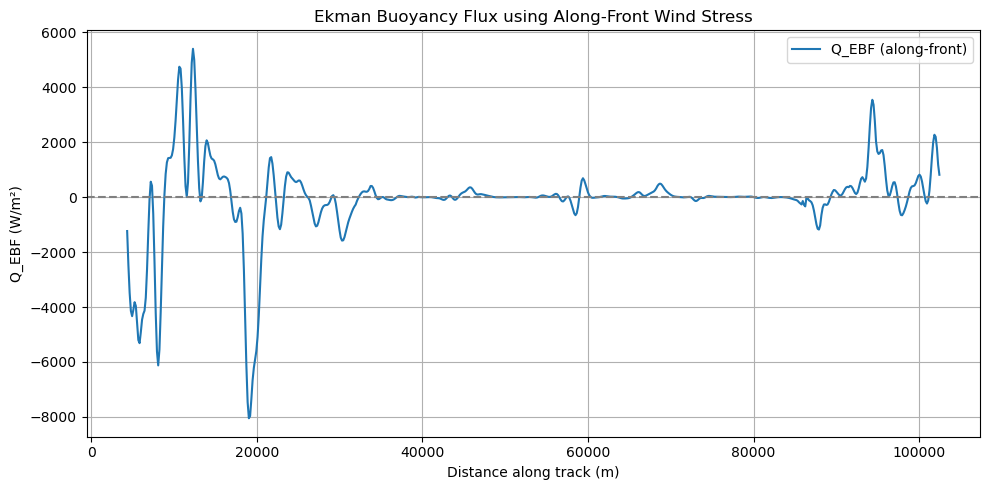

In [ ]:
# # Clean up invalid points (optional but recommended)

mask = (~np.isnan(Q_EBF)) & (~np.isnan(dbdx_reg)) & (~np.isnan(tau_along_reg)) & (~np.isnan(alpha_reg)) & (alpha_reg > 1e-6)

df_Q = pd.DataFrame({
    "distance_m": d_reg[mask],
    "tau_along": tau_along_reg[mask],
    "alpha": alpha_reg[mask],
    "dbdx": dbdx_reg[mask],
    "Q_EBF": Q_EBF[mask]
})


plt.figure(figsize=(10, 5))
plt.plot(df_Q["distance_m"], df_Q["Q_EBF"], label="Q_EBF (along-front)")
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Distance along track (m)")
plt.ylabel("Q_EBF (W/m²)")
plt.title("Ekman Buoyancy Flux using Along-Front Wind Stress")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



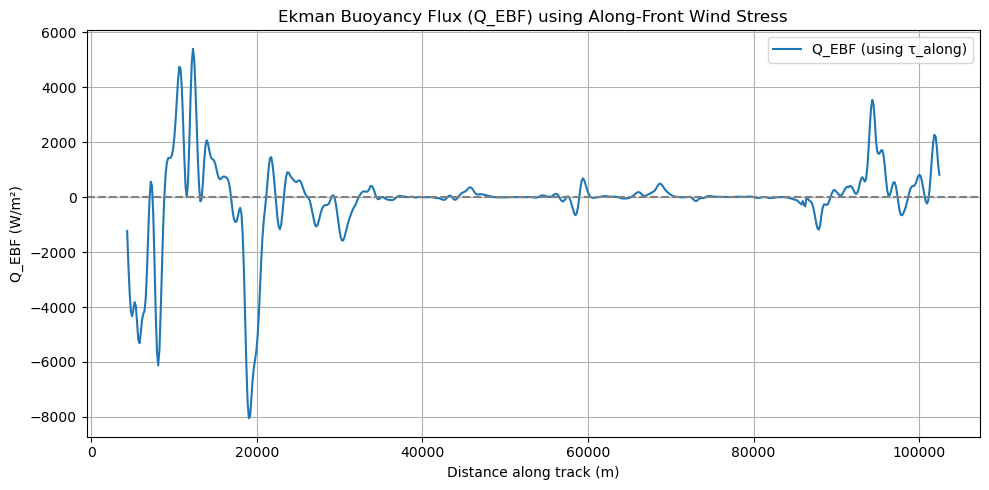

In [ ]:
# If not cleaning up invalid points

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(d_reg, Q_EBF, label='Q_EBF (using τ_along)')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Distance along track (m)")
plt.ylabel("Q_EBF (W/m²)")
plt.title("Ekman Buoyancy Flux (Q_EBF) using Along-Front Wind Stress")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

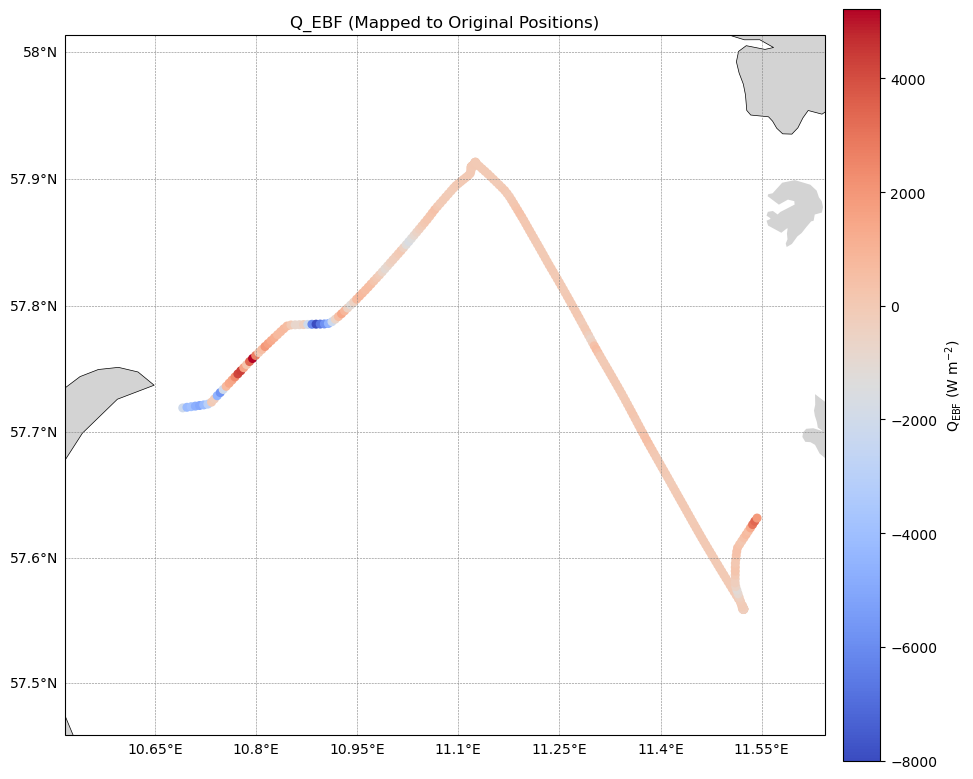

In [ ]:
# Interpolate Q_EBF back to df_clean["dist_m"] (same as Longitude/Latitude)
Q_EBF_interp = np.interp(df_clean["dist_m"], d_reg, Q_EBF, left=np.nan, right=np.nan)

# Then plot it
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Define extent
lat_min, lat_max = df_clean['Latitude'].min(), df_clean['Latitude'].max()
lon_min, lon_max = df_clean['Longitude'].min(), df_clean['Longitude'].max()
extent = [lon_min - 0.1, lon_max + 0.1, lat_min - 0.1, lat_max + 0.1]
ax.set_extent(extent, crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

gl = ax.gridlines(draw_labels=True, linewidth=0.4, color="gray", linestyle="--")
gl.top_labels = False
gl.right_labels = False

# Use interpolated Q_EBF
sc = ax.scatter(df_clean['Longitude'], df_clean['Latitude'],
                c=Q_EBF_interp, cmap='coolwarm', s=30,
                transform=ccrs.PlateCarree())

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Q$_{\\mathrm{EBF}}$ (W m$^{-2}$)')

ax.set_title('Q_EBF (Mapped to Original Positions)')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
print(pd.Series(Q_EBF).describe())


count     655.000000
mean      -79.383827
std      1456.789321
min     -8047.752778
25%       -80.562633
50%         3.717330
75%       206.631194
max      5396.035913
dtype: float64


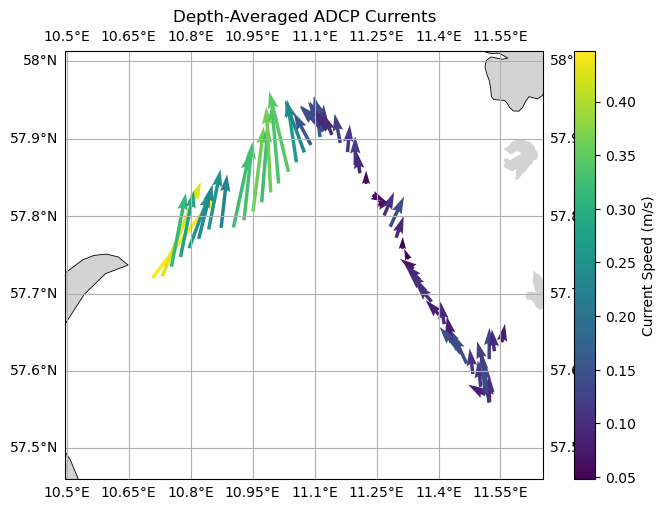

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Depth-averaged current
u_avg = ds["east_velocity"].mean(dim="depth")
v_avg = ds["north_velocity"].mean(dim="depth")

# Extract positions and convert to numpy
lon = ds["lon"].values
lat = ds["lat"].values
u = u_avg.values
v = v_avg.values

# Optional: thin the data for readability
skip = 1  # plot every 5th arrow
lon = lon[::skip]
lat = lat[::skip]
u = u[::skip]
v = v[::skip]

# Plot
plt.figure(figsize=(7, 5))
ax = plt.axes(projection=ccrs.Mercator())

# Set extent with padding
buffer = 0.1
ax.set_extent([
    np.nanmin(lon) - buffer, np.nanmax(lon) + buffer,
    np.nanmin(lat) - buffer, np.nanmax(lat) + buffer
], crs=ccrs.PlateCarree())

# Base map
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.gridlines(draw_labels=True)

speed = np.sqrt(u**2 + v**2)
# Plot quiver
q = ax.quiver(
    lon, lat, u, v, speed, cmap='viridis',
    transform=ccrs.PlateCarree(), scale=2
)
ax.quiverkey(q, 0.9, -0.1, 0.5, '0.5 m/s', labelpos='E')


plt.colorbar(q, ax=ax, label='Current Speed (m/s)')
plt.title("Depth-Averaged ADCP Currents")
plt.tight_layout()
plt.show()


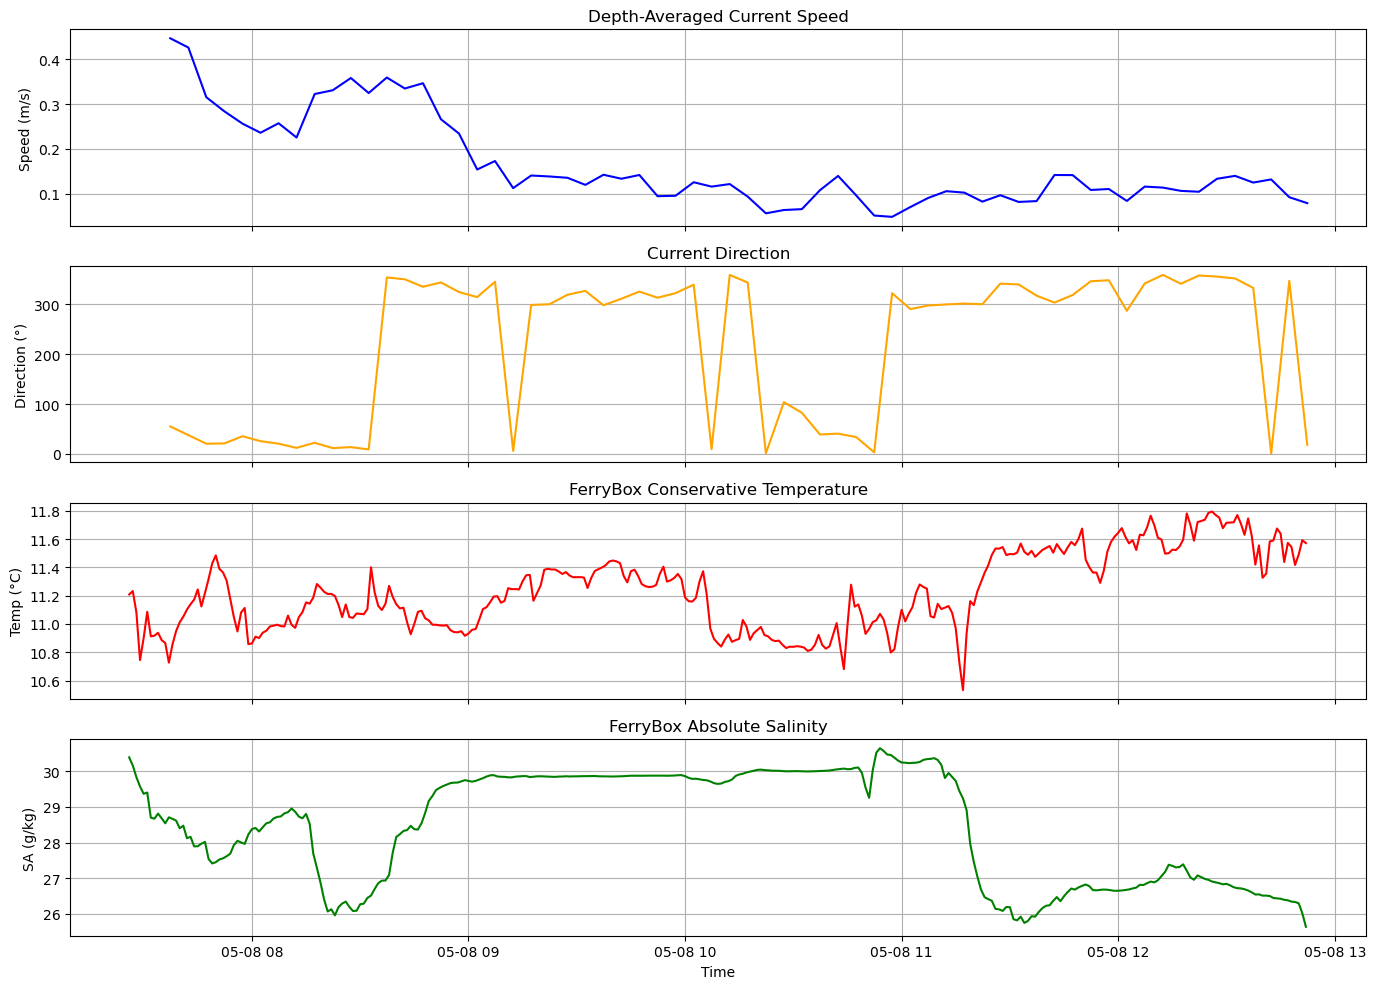

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Filter FerryBox to ADCP time range
start_time = pd.to_datetime(ds.time.values[0])
end_time   = pd.to_datetime(ds.time.values[-1])
mask_fb = (df_clean['datetime'] >= start_time) & (df_clean['datetime'] <= end_time)
df_fb_matched = df_clean[mask_fb]

# Current speed and direction
u_avg = ds["east_velocity"].mean(dim="depth")
v_avg = ds["north_velocity"].mean(dim="depth")
speed = np.sqrt(u_avg**2 + v_avg**2)
theta_current = np.degrees(np.arctan2(u_avg, v_avg)) % 360

# Plot
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axs[0].plot(ds["time"], speed, label="Current Speed", color="blue")
axs[0].set_ylabel("Speed (m/s)")
axs[0].set_title("Depth-Averaged Current Speed")
axs[0].grid(True)

axs[1].plot(ds["time"], theta_current, label="Current Direction", color="orange")
axs[1].set_ylabel("Direction (°)")
axs[1].set_title("Current Direction")
axs[1].grid(True)

axs[2].plot(df_fb_matched['datetime'], df_fb_matched['CT'], label="Conservative Temp (CT)", color="red")
axs[2].set_ylabel("Temp (°C)")
axs[2].set_title("FerryBox Conservative Temperature")
axs[2].grid(True)

axs[3].plot(df_fb_matched['datetime'], df_fb_matched['SA'], label="Absolute Salinity (SA)", color="green")
axs[3].set_ylabel("SA (g/kg)")
axs[3].set_title("FerryBox Absolute Salinity")
axs[3].grid(True)
axs[3].set_xlabel("Time")

plt.tight_layout()
plt.show()


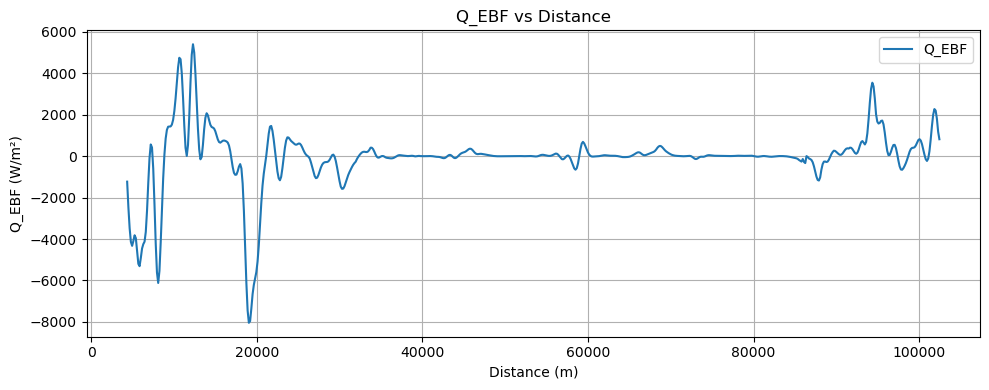

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(d_reg, Q_EBF, label="Q_EBF")
plt.xlabel("Distance (m)")
plt.ylabel("Q_EBF (W/m²)")
plt.title("Q_EBF vs Distance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



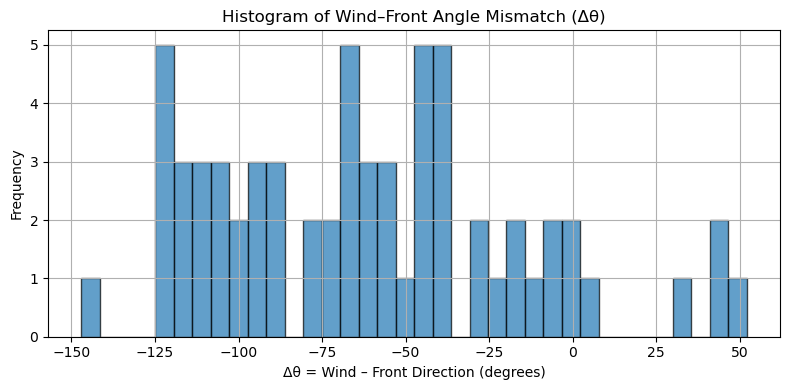

In [ ]:
#Plot Distribution of Δθ (Wind–Front Angle Mismatch)

import matplotlib.pyplot as plt

# Compute angle mismatch between wind and current (front) in degrees
delta_theta_deg = (np.degrees(theta_wind_interp) - np.degrees(theta_current_rad) + 360) % 360
delta_theta_deg = (delta_theta_deg + 180) % 360 - 180  # Now in range [-180, 180]

# Plot histogram of angle mismatches
plt.figure(figsize=(8, 4))
plt.hist(delta_theta_deg, bins=36, edgecolor='k', alpha=0.7)
plt.xlabel("Δθ = Wind – Front Direction (degrees)")
plt.ylabel("Frequency")
plt.title("Histogram of Wind–Front Angle Mismatch (Δθ)")
plt.grid(True)
plt.tight_layout()
plt.show()


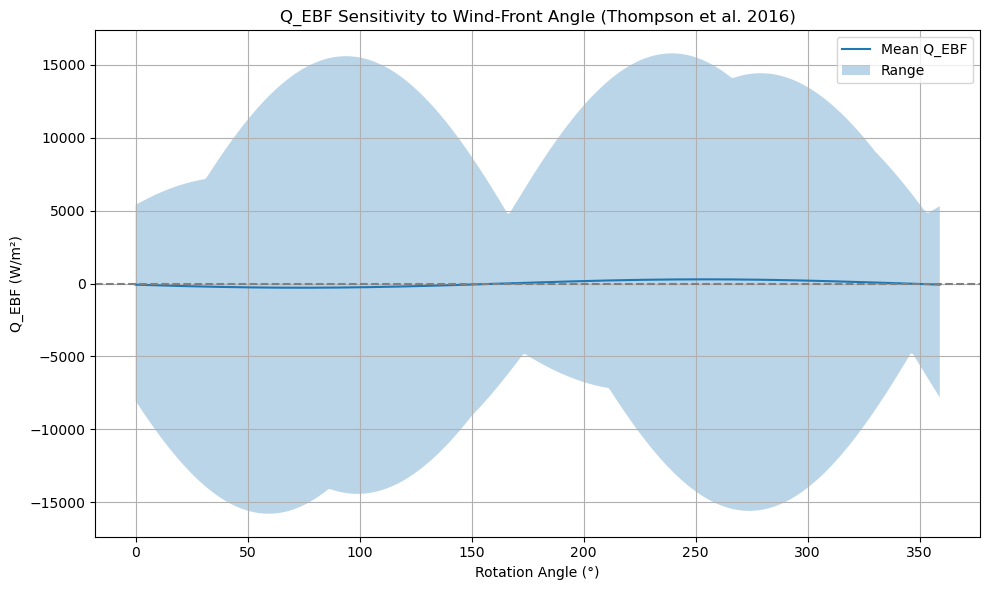

In [ ]:
angles_deg = np.arange(0, 360)
Q_EBF_range = []

for angle in angles_deg:
    # Rotate wind direction artificially
    theta_rotated = (theta_wind_interp + np.radians(angle)) % (2 * np.pi)
    
    # Project onto front direction
    delta_theta_rot = theta_rotated - theta_current_rad
    tau_along_rot = tau_interp * np.cos(delta_theta_rot)
    
    # Interpolate to grid
    tau_along_reg_rot = np.interp(d_reg, dist_adcp, tau_along_rot)
    
    # Compute EBF
    Q_EBF_rot = - (dbdx_reg * tau_along_reg_rot) * (Cp / (alpha_reg * g * f))
    Q_EBF_range.append(Q_EBF_rot)

# Convert to array for easier analysis
Q_EBF_range = np.array(Q_EBF_range)  # shape: (360, len(d_reg))

# Plot range across rotation
plt.figure(figsize=(10, 6))
plt.plot(angles_deg, np.nanmean(Q_EBF_range, axis=1), label="Mean Q_EBF")
plt.fill_between(angles_deg,
                 np.nanmin(Q_EBF_range, axis=1),
                 np.nanmax(Q_EBF_range, axis=1),
                 alpha=0.3, label="Range")
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Rotation Angle (°)")
plt.ylabel("Q_EBF (W/m²)")
plt.title("Q_EBF Sensitivity to Wind-Front Angle (Thompson et al. 2016)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Check first and last rows of ADCP data

# Compute u, v
u_avg = ds["east_velocity"].mean(dim="depth")
v_avg = ds["north_velocity"].mean(dim="depth")

# Compute speed and direction
speed = np.sqrt(u_avg**2 + v_avg**2)
theta = (np.degrees(np.arctan2(u_avg, v_avg)) + 360) % 360

# Combine and print last 10
for i in range(-10, 0):
    print(f"{ds['time'].values[i]} → speed: {speed.values[i]:.3f} m/s, direction: {theta.values[i]:.1f}°")



# Combine and print last 10
for i in range(0, 10):
    print(f"{ds['time'].values[i]} → speed: {speed.values[i]:.3f} m/s, direction: {theta.values[i]:.1f}°")


2025-05-08T12:07:22.000000000 → speed: 0.116 m/s, direction: 342.3°
2025-05-08T12:12:24.000000000 → speed: 0.113 m/s, direction: 359.4°
2025-05-08T12:17:22.000000000 → speed: 0.106 m/s, direction: 341.7°
2025-05-08T12:22:23.000000000 → speed: 0.104 m/s, direction: 358.2°
2025-05-08T12:27:22.000000000 → speed: 0.133 m/s, direction: 356.1°
2025-05-08T12:32:23.000000000 → speed: 0.140 m/s, direction: 352.3°
2025-05-08T12:37:25.000000000 → speed: 0.125 m/s, direction: 333.3°
2025-05-08T12:42:23.000000000 → speed: 0.132 m/s, direction: 0.6°
2025-05-08T12:47:24.000000000 → speed: 0.092 m/s, direction: 347.5°
2025-05-08T12:52:23.000000000 → speed: 0.079 m/s, direction: 18.0°
2025-05-08T07:17:23.000000000 → speed: nan m/s, direction: nan°
2025-05-08T07:22:23.000000000 → speed: nan m/s, direction: nan°
2025-05-08T07:27:23.000000000 → speed: nan m/s, direction: nan°
2025-05-08T07:32:24.000000000 → speed: nan m/s, direction: nan°
2025-05-08T07:37:22.000000000 → speed: 0.447 m/s, direction: 54.9°


In [ ]:
df_wind

,airtemp,humidity,airpressure,windspeed,winddir,tau,tau_x,tau_y,theta_wind,u_wind,v_wind,datetime
Time,,,,,,,,,,,,
2025-05-08 07:18:00,10.9,65,1019.7,3.7,28,0.025601,-0.012019,-0.022604,0.488692,-1.737045,-3.266906,2025-05-08 07:18:00
2025-05-08 07:19:00,10.8,65,1019.7,4.7,29,0.041324,-0.020034,-0.036143,0.506145,-2.278605,-4.110713,2025-05-08 07:19:00
2025-05-08 07:20:00,10.6,66,1019.6,5.4,36,0.054583,-0.032083,-0.044158,0.628319,-3.174040,-4.368692,2025-05-08 07:20:00
2025-05-08 07:21:00,10.5,67,1019.6,6.0,34,0.067408,-0.037694,-0.055884,0.593412,-3.355157,-4.974225,2025-05-08 07:21:00
2025-05-08 07:22:00,10.3,68,1019.7,5.9,28,0.065232,-0.030625,-0.057596,0.488692,-2.769882,-5.209391,2025-05-08 07:22:00
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08 12:48:00,10.4,65,1018.8,8.4,342,0.132078,0.040814,-0.125613,5.969026,2.595743,-7.988875,2025-05-08 12:48:00
2025-05-08 12:49:00,10.4,65,1018.8,9.7,338,0.176122,0.065977,-0.163298,5.899213,3.633684,-8.993683,2025-05-08 12:49:00
2025-05-08 12:50:00,10.4,62,1018.9,8.8,326,0.144991,0.081078,-0.120203,5.689773,4.920898,-7.295531,2025-05-08 12:50:00


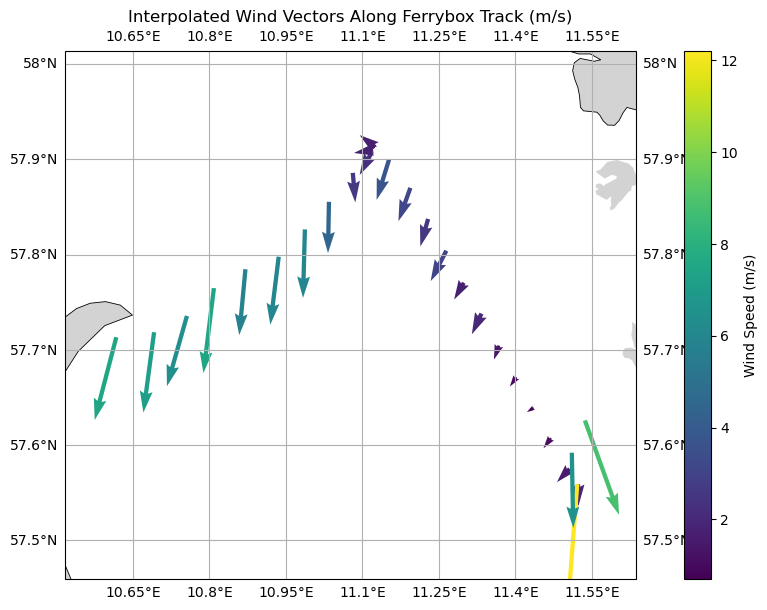

In [ ]:
# Interpolera vinddatan till Ferrybox datan

from scipy.interpolate import interp1d

from scipy.interpolate import interp1d

# Interpolation functions using the existing DatetimeIndex
interp_u = interp1d(df_wind.index.astype(np.int64), df_wind['u_wind'], bounds_error=False, fill_value=np.nan)
interp_v = interp1d(df_wind.index.astype(np.int64), df_wind['v_wind'], bounds_error=False, fill_value=np.nan)

# Apply interpolation to df_clean's datetime values
df_clean['u_wind'] = interp_u(df_clean['datetime'].astype(np.int64))
df_clean['v_wind'] = interp_v(df_clean['datetime'].astype(np.int64))




import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Thin data to improve readability
skip = 12
lon = df_clean['Longitude'].values[::skip]
lat = df_clean['Latitude'].values[::skip]
u = df_clean['u_wind'].values[::skip]
v = df_clean['v_wind'].values[::skip]
speed = np.sqrt(u**2 + v**2)

# Plot
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mercator())

buffer = 0.1
ax.set_extent([
    np.nanmin(lon) - buffer, np.nanmax(lon) + buffer,
    np.nanmin(lat) - buffer, np.nanmax(lat) + buffer
], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.gridlines(draw_labels=True)

q = ax.quiver(lon, lat, u, v, speed, cmap='viridis',
              scale=50, transform=ccrs.PlateCarree())
ax.quiverkey(q, 0.9, -0.1, 5, '5 m/s', labelpos='E')

plt.colorbar(q, ax=ax, label='Wind Speed (m/s)')
plt.title("Interpolated Wind Vectors Along Ferrybox Track (m/s)")
plt.tight_layout()
plt.show()



In [ ]:
# Ensure 'datetime' column is in datetime format
df_wind['datetime'] = pd.to_datetime(df_wind['datetime'])

# Filter rows where the date is 2025-06-08
filtered_values_06 = df_wind[df_wind['datetime'].dt.date == pd.to_datetime('2025-05-06').date()]['winddir'].values
filtered_values_07 = df_wind[df_wind['datetime'].dt.date == pd.to_datetime('2025-05-07').date()]['winddir'].values
filtered_values_08 = df_wind[df_wind['datetime'].dt.date == pd.to_datetime('2025-05-08').date()]['winddir'].values


In [ ]:
mean_06 = np.nanmean(filtered_values_06)
mean_07 = np.nanmean(filtered_values_07)
mean_08 = np.nanmean(filtered_values_08)

c:\Users\Sussi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Sussi\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
print(mean_06)
print(mean_07)
print(mean_08)

nan
nan
79.48358208955224
